In [ ]:
import tensorflow as tf,os,random,matplotlib.pyplot as plt,cv2,numpy as np,scipy.misc,numpy.random as rng,glob,math,keras,nibabel as nib
from tqdm import tqdm #reading nifti images
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

In [ ]:
!git clone https://github.com/twpkevin06222/Liver-Segmentation-Project-.git medical_imaging

In [ ]:
!pip install nibabel

In [ ]:
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
#from read_data import load_images
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#Data Preprocessing

In [ ]:
#Extracting files "Dont run"
import gzip
import shutil
import os

def extract_gz(gz_file, extract_folder):
    # Create the extraction folder if it doesn't exist
    if not os.path.exists(extract_folder):
        os.makedirs(extract_folder)

    # Open the .gz file for reading
    with gzip.open(gz_file, 'rb') as f_in:
        # Extract the file name from the .gz file
        filename = os.path.basename(gz_file).replace('.gz', '')

        # Create the output file path
        extract_path = os.path.join(extract_folder, filename)

        # Open the output file for writing
        with open(extract_path, 'wb') as f_out:
            # Copy the contents from the .gz file to the output file
            shutil.copyfileobj(f_in, f_out)

    print(f"File extracted to: {extract_path}")

# Example usage:
gz_file = "/content/medical_imaging/tmp/tmp_img/img_new_label/label_0.nii.gz"
extract_folder = "/content/None"
extract_gz(gz_file, extract_folder)


File extracted to: /content/None/label_0.nii


In [ ]:
# @title Dont Run
import nibabel as nib #"Dont run"
import numpy as np
import matplotlib.pyplot as plt
import os

def nifti_to_rgb(nii_file, output_folder):
    # Load NIfTI file
    nii_img = nib.load(nii_file)

    # Extract image data
    img_data = nii_img.get_fdata()

    # Normalize data to [0, 255]
    img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data)) * 255

    # Convert to uint8
    img_data = img_data.astype(np.uint8)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save each slice as an RGB image
    for i in range(img_data.shape[2]):
        # Plot as RGB image
        plt.imshow(img_data[:, :, i], cmap='gray')
        plt.axis('off')
        output_file = os.path.join(output_folder, f"slice_{i:03d}.png")
        plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
        plt.close()

# Example usage:
nii_file = "/content/None/label_0.nii"
output_folder = "/content/Untitled Folder"
nifti_to_rgb(nii_file, output_folder)

In [ ]:
def three_to_two(path, label='FALSE'):
    ff = sorted(glob.glob(path))
    images =[]
    for f in range(len(ff)):
        a = nib.load(ff[f])
        a = a.get_data()
        for i in range(a.shape[2]):
            images.append(a[:,:,i])
    images = np.asarray(images)
    #images = images.reshape(-1, 128,128, 1) # dimension to feed into the network
    return images

def min_max_norm(images):
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi)/ (m - mi)
    return images

def label_outliers(img_labels):
    img_labels[img_labels>1]=1
    img_labels[img_labels<0]=0
    return img_labels

#Image for training
images = three_to_two(path='medical_imaging/tmp/tmp_img/img_new/*')
x_data = min_max_norm(images)

#labels
img_labels = three_to_two(path='medical_imaging/tmp/tmp_img/img_new_label/*')
y_data = label_outliers(img_labels)

#Test Image
img_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img/*')
x_test = min_max_norm(img_test)

#Test Labels
label_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img_label/*')
y_test = label_outliers(label_test)

<ipython-input-7-281133919471>:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  a = a.get_data()


In [ ]:
def add_label_noise(labels, noise_ratio=0.00):
    flip_indices = np.random.choice(len(labels), size=int(len(labels) * noise_ratio), replace=False)
    # Flip the labels (0->1 and 1->0)
    labels[flip_indices] = 1 - labels[flip_indices]
    return labels

# Adding 1% noise to the training labels
y_data_noisy = add_label_noise(y_data.copy()) # Use .copy() to avoid modifying original y_data


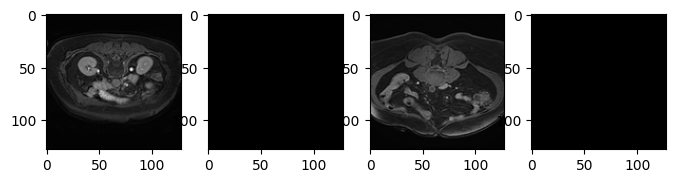

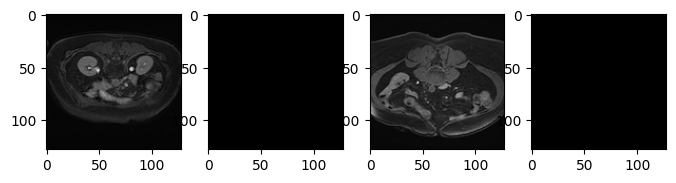

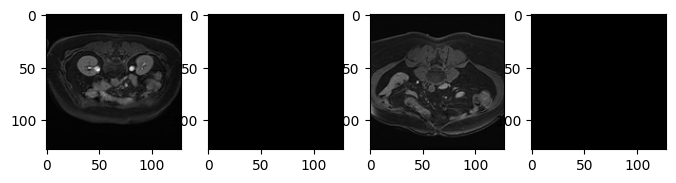

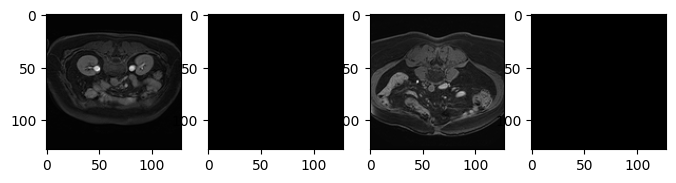

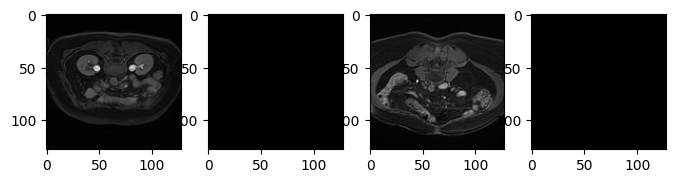

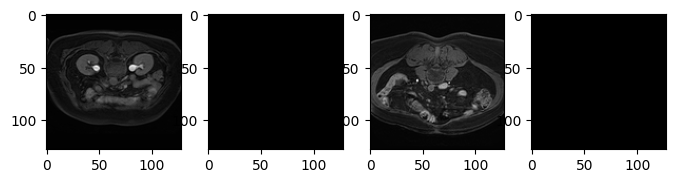

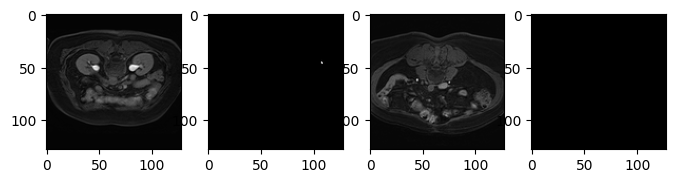

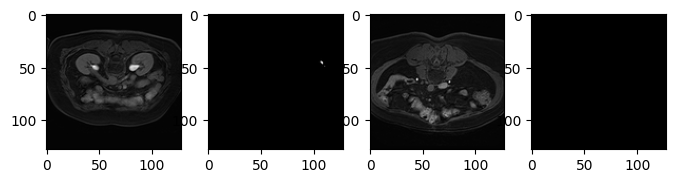

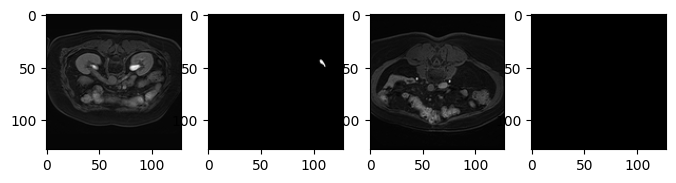

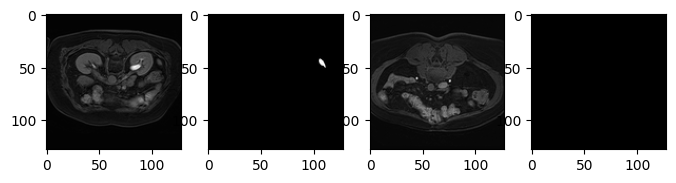

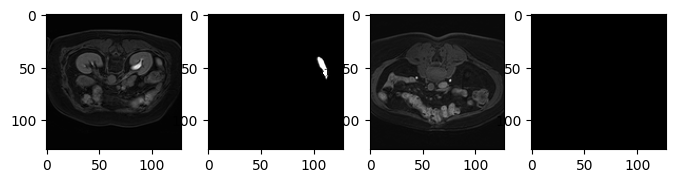

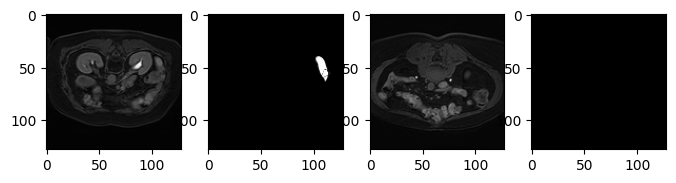

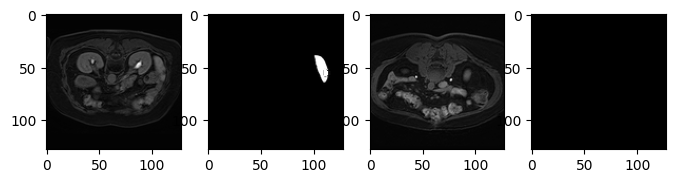

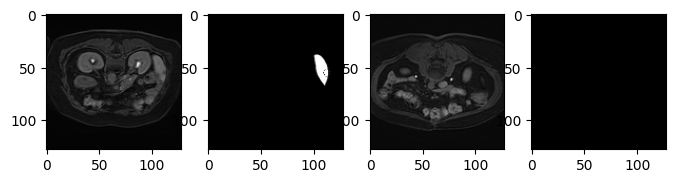

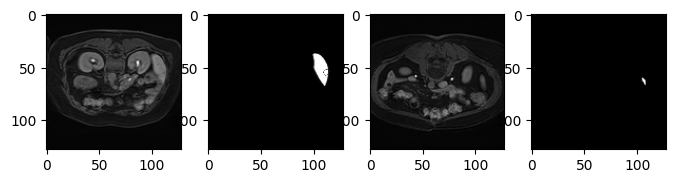

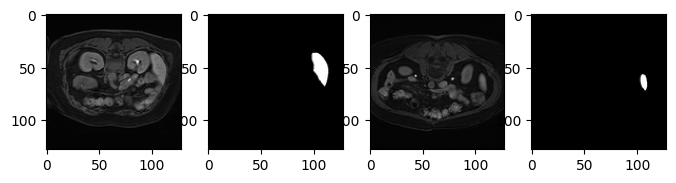

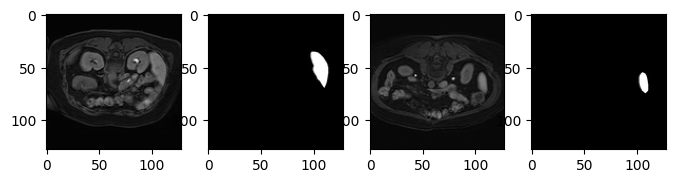

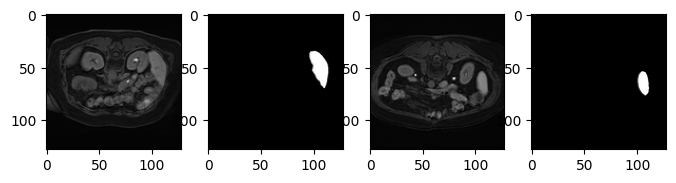

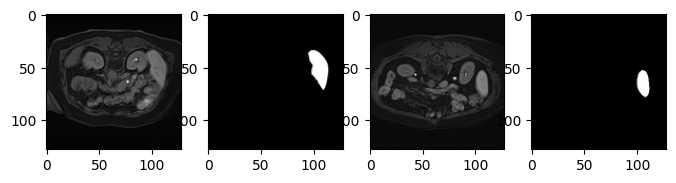

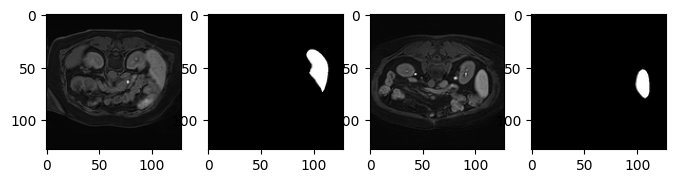

In [ ]:
#show 1st 20 slices

for i in range(20):
    fig, ax = plt.subplots(1,4, figsize = (8,4))
    ax[0].imshow(x_data[i], cmap='gray')
    ax[1].imshow(y_data_noisy[i], cmap='gray')
    ax[2].imshow(x_test[i], cmap='gray')
    ax[3].imshow(y_test[i], cmap='gray')

plt.show()

In [ ]:
x_data = x_data[:,:,:,np.newaxis] # same as reshape (-1,128,128,1)
y_data = y_data_noisy[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]
y_test = y_test[:,:,:,np.newaxis]

print('Dimension for training data:', x_data.shape)
print('Dimension for training data labels:', y_data.shape)
print('Dimension for test data:', x_test.shape)
print('Dimension for test data labels:', y_test.shape)

Dimension for training data: (3036, 128, 128, 1)
Dimension for training data labels: (3036, 128, 128, 1)
Dimension for test data: (735, 128, 128, 1)
Dimension for test data labels: (735, 128, 128, 1)


In [ ]:
import pandas as pd
import numpy as np

# Assuming x_data is your 4-dimensional array
x_data_reshaped = x_data.reshape(x_data.shape[0], -1)  # Flatten the last dimension

# Create DataFrame from reshaped array
df = pd.DataFrame(x_data_reshaped)

# Display the DataFrame
df.head(5)


,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844
1,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844
2,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844
3,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844
4,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844


#Data Splitting

In [ ]:
 from sklearn.utils import shuffle

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state =42)
x_test, y_test = shuffle(x_test, y_test, random_state= 42)

In [ ]:
np.random.seed = 42
IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS= 128,128,1

#Loss Functions

In [ ]:
#Dont run
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())

def hausdorff_distance(y_true, y_pred):
    surface_distances = tf.reduce_sum(y_true * y_pred, axis=[1, 2]) / tf.reduce_sum(y_true + y_pred, axis=[1, 2])
    hausdorff_distance = tf.reduce_max(surface_distances)
    return hausdorff_distance

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    total_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (total_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())



beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def logcsh_loss(y_true, y_pred):
    loss = tf.math.log(tf.math.cosh(y_pred - y_true))
    return tf.reduce_mean(loss)

*U net*
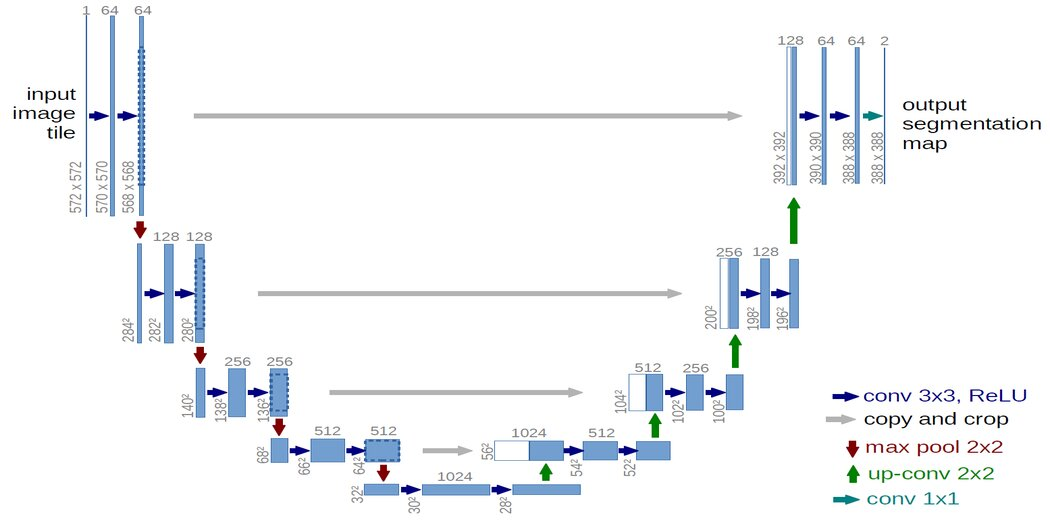

#Architecture
Deconvolution is often used in tasks like image segmentation, where the goal is to predict a mask or label for each pixel in an image. By increasing the spatial dimensions, the network can produce more precise outputs.

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) ##Used for normailizing the pixal values

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name = "Layer1")(s)  #(128x128x3) * (3x3x16) = (126X 126 x 16)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)  #(126X 126 x 16) * (3x3x16) = (124X 124 x 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)  ##(124X 124 x 16) * (2x2) = (123X 123)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name = "Layer2")(p1)  #(123X 123) * (3x3x32) = (121 x 121 x 32)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2) #(121 x 121 x 32) * (3x3x32) = (119 x 119 x 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2) #(119 x 119 x 32) * (2x2) = (118 x 118)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2) #(118x118) * (3x3x64) = (116x116x64)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)  #(116x116x64) *(3x3x64) = (114x114x64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)  #(114x114x64) *(2x2) = (113x113)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)  #(113x113) *(3x3x128) = (111 x111 x128)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)  #(111 x111 x128) *(3x3x128) = (109 x109 x128)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4) #(109 x109 x128) *(2x2) = (108x108)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4) #(108 x 108) * (3,3,256) = (106 x 106 x 256)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)  #(106 x 106 x 256) * (3,3,256) = (104 x104 x256)

#Expansive path   Decovloution :output_dim = (img - 1) * strides + kernel_size + 2 * padding
#It performs a deconvolution or upconvolution operation, essentially the opposite of a standard convolution.
#padding = same ===> padding = (filter - 1) // 2
"""
Padding == ‘Same’:
Output Height (H) = Input Height (H1) × Stride
Output Width (W) = Input Width (W1) × Stride
Padding == ‘Valid’:
Output Height (H) = (Input Height (H1) - 1) × Stride + Kernel Height (HF) - 2 × p
Output Width (W) = (Input Width (W1) - 1) × Stride + Kernel Width (WF) - 2 × p
"""


u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)   #(104 x104 x256) .* (2,2,128)  = (208,208,128)
#channels = 128 ,

u6 = tf.keras.layers.concatenate([u6, c4])     #c4 -->109  ,u6 ---->208  ==> resultant is (16,16,256)
u6.shape
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss=logcsh_loss, metrics=['accuracy'])
model.compile(optimizer=Adam(1e-2), loss='binary_crossentropy', metrics=[dice_coef,jaccard_index,precision,specificity,hausdorff_distance,recall,sensitivity,'accuracy'])
#model.summary()

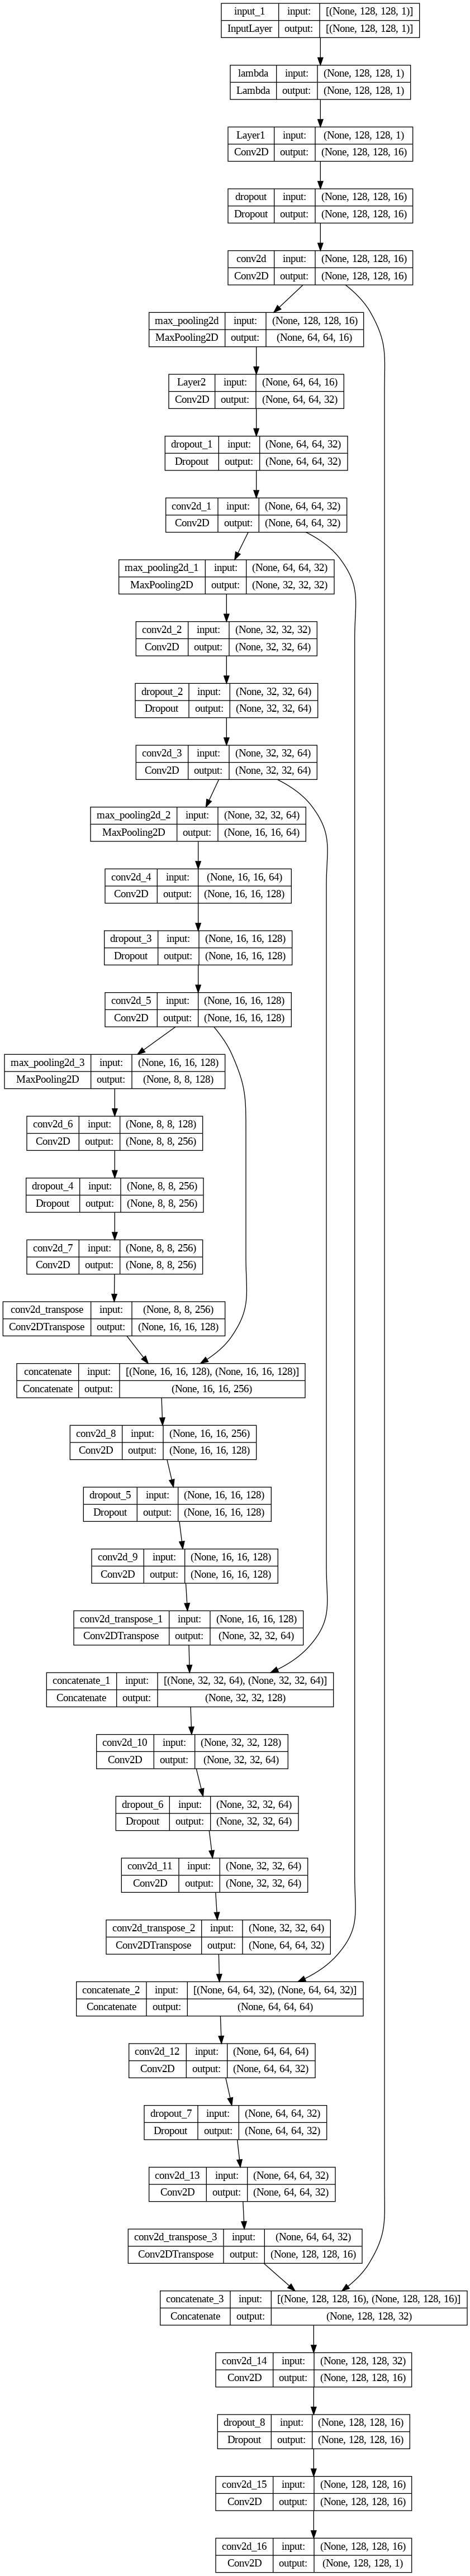

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Define your callbacks
filepath = 'saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'  # Define the filepath with proper placeholders
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')  # Save the model with the highest validation accuracy
#early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)  # Logging to CSV file


In [ ]:
# Assuming model is defined elsewhere
results = model.fit(x_data, y_data, validation_data=(x_val, y_val),
                    batch_size=16, epochs=20, callbacks=[checkpoint, log_csv])

Epoch 1/20
189/190 [============================>.] - ETA: 0s - loss: 0.2343 - dice_coef: 0.0631 - jaccard_index: 0.0326 - precision: 0.0000e+00 - specificity: 0.9998 - hausdorff_distance: 0.0479 - recall: 0.0000e+00 - sensitivity: 0.0000e+00 - accuracy: 0.9210
Epoch 1: val_accuracy improved from -inf to 0.91823, saving model to saved_models/weights-improvement-01-0.92.hdf5
190/190 [==============================] - 9s 49ms/step - loss: 0.2344 - dice_coef: 0.0632 - jaccard_index: 0.0326 - precision: 0.0000e+00 - specificity: 0.9998 - hausdorff_distance: 0.0479 - recall: 0.0000e+00 - sensitivity: 0.0000e+00 - accuracy: 0.9209 - val_loss: 0.2376 - val_dice_coef: 0.0738 - val_jaccard_index: 0.0384 - val_precision: 0.0000e+00 - val_specificity: 0.9997 - val_hausdorff_distance: 0.0583 - val_recall: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_accuracy: 0.9182
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


189/190 [============================>.] - ETA: 0s - loss: 0.2317 - dice_coef: 0.0661 - jaccard_index: 0.0342 - precision: 0.0000e+00 - specificity: 0.9998 - hausdorff_distance: 0.0502 - recall: 0.0000e+00 - sensitivity: 0.0000e+00 - accuracy: 0.9209
Epoch 2: val_accuracy did not improve from 0.91823
190/190 [==============================] - 9s 49ms/step - loss: 0.2317 - dice_coef: 0.0661 - jaccard_index: 0.0342 - precision: 0.0000e+00 - specificity: 0.9998 - hausdorff_distance: 0.0503 - recall: 0.0000e+00 - sensitivity: 0.0000e+00 - accuracy: 0.9209 - val_loss: 0.2325 - val_dice_coef: 0.0736 - val_jaccard_index: 0.0382 - val_precision: 0.0000e+00 - val_specificity: 0.9998 - val_hausdorff_distance: 0.0562 - val_recall: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_accuracy: 0.9182
Epoch 3/20
189/190 [============================>.] - ETA: 0s - loss: 0.2290 - dice_coef: 0.0689 - jaccard_index: 0.0357 - precision: 0.0000e+00 - specificity: 0.9998 - hausdorff_distance: 0.0522 - recall: 

#Ploting Loss Vs Epochs

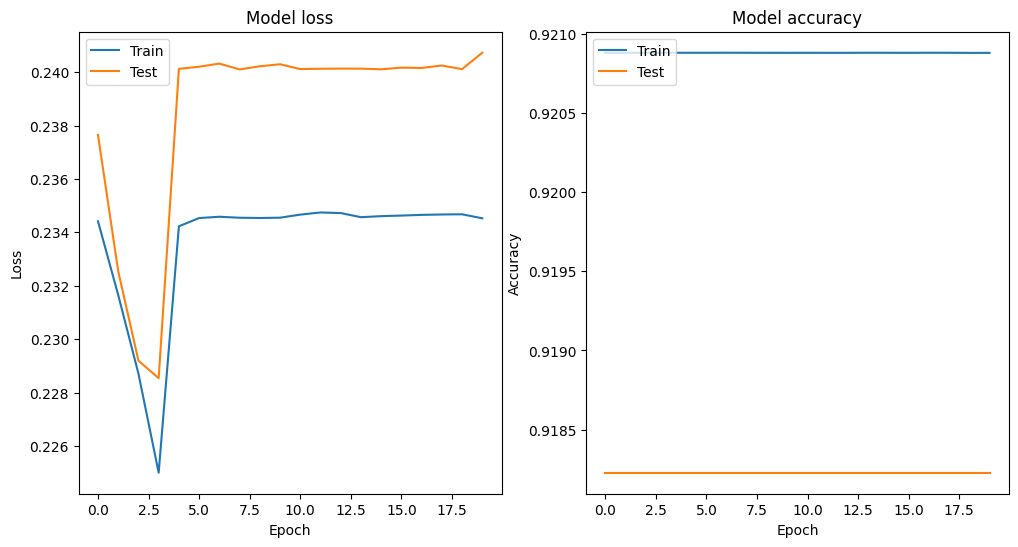

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
